In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from jax.random import split, PRNGKey
def init_RWKV_params(input_size, emb_size, h_size,  num_layer, out_size, Ny, Nx, key):
    key, emb_key, init_x_key, init_y_key, last_x1_key, last_x2_key, last_y1s_key, last_y1e_key, last_y2_key, key_tout, key_txout, key_talpha_out, key_tbeta_out, key_tlast_x, key_clast_x, key_cxout = split(key, 16)
    wemb = random.uniform(emb_key, (input_size, emb_size), minval=-1e-4, maxval=1e-4) #input hasn't been connected
    x_init = random.uniform(init_x_key, (Nx, emb_size), minval=-1e-4, maxval=1e-4)
    y_init = random.uniform(init_y_key, (Ny, emb_size), minval=-1e-4, maxval=1e-4)
    last_x1_init = random.uniform(last_x1_key, (Nx, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_x2_init = random.uniform(last_x2_key, (Nx, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_y1s_init = random.uniform(last_y1s_key, (Ny+1, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_y1e_init = random.uniform(last_y1e_key, (Ny+1, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_y2_init = random.uniform(last_y2_key, (Ny, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    t_alpha_init_x, t_alpha_init_y, t_beta_init_x, t_beta_init_y = jnp.zeros((Nx, num_layer, h_size)), jnp.zeros((Ny, num_layer, h_size)), jnp.zeros((Nx, num_layer, h_size)), jnp.zeros((Ny, num_layer, h_size))
    t_xout = random.normal(key_tout, (Ny, Nx, num_layer, emb_size, 2*emb_size))
    t_alphaout = random.normal(key_talpha_out, (Ny, Nx, num_layer, h_size, 2*h_size))
    t_betaout = random.normal(key_tbeta_out, (Ny, Nx, num_layer, h_size, 2*h_size))
    c_xout = random.normal(key_cxout, (Ny, Nx, num_layer, emb_size, 2*emb_size))    
    emb_size, h_size = 2*emb_size, 2*h_size #tensor product the input from two directions and concantenate the hidden state
    wln_in, bln_in, wln_out, bln_out = jnp.ones((Ny, Nx, emb_size)), jnp.zeros((Ny, Nx, emb_size)), jnp.ones((Ny, Nx, emb_size)), jnp.zeros((Ny, Nx, emb_size))  #in&out layer_norm params
    wln, bln = jnp.ones((2, Ny, Nx, num_layer, emb_size)), jnp.zeros((2, Ny, Nx, num_layer, emb_size))  #time&channel layer_norm params

    # time mixing params
    decay = jnp.tile(-5 + jnp.array([8*(jnp.arange(h_size)/(h_size-1))**(0.7 + 1.3*i/(num_layer-1)) for i in range(num_layer)]), (Ny, Nx, 1, 1))
    bonus = jnp.tile(0.5*(jnp.arange(h_size)%3-1)+jnp.log(0.3), (Ny, Nx, num_layer, 1))
    t_mix_k = jnp.tile(jnp.array([(jnp.arange(emb_size) / emb_size) ** (1 - i / num_layer) for i in range(num_layer)]), (Ny, Nx, 1, 1))
    t_mix_v = t_mix_k + jnp.transpose(jnp.tile(jnp.arange(num_layer) * 0.3 / (num_layer - 1), (Ny, Nx, emb_size, 1)), (0, 1, 3, 2))
    t_mix_r = 0.5 * t_mix_k
    t_wk, t_wv, t_wr = jnp.zeros((Ny, Nx, num_layer, h_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, h_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, h_size, emb_size))
    t_wout = jnp.sqrt(h_size/emb_size)*random.normal(key_tout, (Ny, Nx, num_layer, emb_size, h_size))
    t_wlast_x = random.normal(key_tlast_x, (Ny, Nx, num_layer, emb_size, 2*emb_size)) #since last_x is twice larger than x

    # channel mixing params
    c_mix_k, c_mix_r = t_mix_k, t_mix_k
    c_wr, c_wv, c_wk = jnp.zeros((Ny, Nx, num_layer, emb_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, emb_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, emb_size, emb_size))
    c_wlast_x = random.normal(key_clast_x, (Ny, Nx, num_layer, emb_size, 2*emb_size)) #since last_x is twice larger than x
    # output params
    whead, bhead = jnp.tile(jnp.eye(emb_size), (Ny, Nx, 1, 1)), jnp.zeros((Ny, Nx, emb_size))
    wprob, bprob, wphase, bphase = jnp.zeros((out_size, emb_size)), jnp.zeros((out_size)), jnp.zeros((out_size, emb_size)), jnp.zeros((out_size))
    RWKV_cell_params = wln[0], bln[0], wln[1], bln[1], decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wr, t_wv, t_wk, t_wout, t_wlast_x, c_mix_k, c_mix_r, c_wr, c_wv, c_wk, c_wlast_x, t_xout, t_alphaout, t_betaout, c_xout

    return (wemb, x_init, y_init, last_x1_init, last_x2_init, last_y1s_init, last_y1e_init, last_y2_init, t_alpha_init_x, t_alpha_init_y, t_beta_init_x, t_beta_init_y,  wln_in, bln_in, wln_out, bln_out, whead, bhead, wprob, bprob, wphase, bphase, RWKV_cell_params)

In [2]:
def int_to_binary_array(x, num_bits):
    """
    Converts an array of integers to their binary representation arrays with a fixed number of bits.
    This function is designed to be compatible with Jax's vmap for vectorization over an array of integers.

    Parameters:
    - x: An array of integers, the numbers to convert.
    - num_bits: Integer, the fixed number of bits for the binary representation.

    Returns:
    - A 2D Jax array where each row is the binary representation of an integer in 'x'.
    """
    # Create an array of bit positions: [2^(num_bits-1), 2^(num_bits-2), ..., 1]
    powers_of_two = 2 ** jnp.arange(num_bits - 1, -1, -1)

    # Expand dims of x and powers_of_two for broadcasting
    x_expanded = x[:, None]
    powers_of_two_expanded = powers_of_two[None, :]

    # Perform bitwise AND between each number and each power of two, then right shift to get the bit value
    binary_matrix = (x_expanded & powers_of_two_expanded) >> jnp.arange(num_bits - 1, -1, -1)

    return binary_matrix.astype(jnp.int32)  # Ensure the result is integer


def binary_array_to_int(binary_array, num_bits):
    """
    Converts a 2D array of binary representations to their decimal equivalents.

    Parameters:
    - binary_array: A 2D Jax array where each row represents a binary number.

    Returns:
    - A 1D Jax array of integers, the decimal equivalents of the binary representations.
    """
    powers_of_two = 2 ** jnp.arange(num_bits - 1, -1, -1)
    # Multiply each bit by its corresponding power of two and sum the results
    decimals = jnp.dot(binary_array, powers_of_two)
    return decimals

In [13]:
from functools import partial
from jax.lax import scan
from jax.random import categorical

@partial(jax.jit, static_argnames=['fixed_params'])
def sample_prob(params, fixed_params, ny_nx_indices, key):

    Ny, Nx, py, px, mag_fixed, magnetization, num_layer = fixed_params
    int_to_binary = partial(int_to_binary_array, num_bits=px * py)
    
    def scan_fun_1d(carry_1d, indices):
        ny, nx = indices
        
        input_x, input_yi, last_x1, last_x1s, last_x1e, last_x2, last_y1i, last_y2i, t_alpha_state_x1, t_beta_state_x1, t_alpha_state_yi, t_beta_state_yi, key = carry_1d
    
        rnn_input = jnp.concatenate((input_yi, input_x[nx]), axis=0)
        last_state = jnp.concatenate((last_y2i, last_x1s[nx], last_x2[nx], last_x1e[nx]), axis=1)
        t_alpha_state = jnp.concatenate((t_alpha_state_yi, t_alpha_state_x1[nx]), axis=1)
        t_beta_state = jnp.concatenate((t_beta_state_yi, t_beta_state_x1[nx]), axis=1)
        x, t_states, c_states, prob, phase = RWKV_step(rnn_input, (last_state, t_alpha_state, t_beta_state), (last_state), num_layer, RWKV_net_params, jnp.array([ny, nx]))

        key, subkey = split(key)
        block_sample = categorical(subkey, jnp.log(prob))
        probs, phase = prob[block_sample], phase[block_sample]
        last_y2i = last_y1i
        last_y1i, t_alpha_state_yi, t_beta_state_yi= t_states
        input_yi = wemb[block_sample]
        return (input_x, input_yi, last_x1, last_x1s, last_x1e, last_x2, last_y1i, last_y2i, t_alpha_state_x1, t_beta_state_x1, t_alpha_state_yi, t_beta_state_yi, key), (last_y1i, t_alpha_state_yi, t_beta_state_yi, block_sample, probs, phase)

    def scan_fun_2d(carry_2d, indices):  # indices:[[0,0], [0,1], [0,2]...[0,Nx-1]]

        input_x, input_y, last_x1, last_x2, last_y1s, last_y1e, last_y2, t_alpha_state_x, t_beta_state_x, t_alpha_state_y, t_beta_state_y ,key = carry_2d
        ## The shape of last_y1s, last_y1e are (Ny+1) 
        index = indices[0, 0]
        print(last_y1s[index][None, ...].shape)
        print(last_x1[:-1].shape)
        last_x1s = jnp.concatenate((last_y1s[index][None, ...], last_x1[:-1]), axis=0)
        last_x1e = jnp.concatenate((last_x1[1:], last_y1e[index][None, ...]), axis=0)
        carry_1d = input_x, input_y[index], last_x1, last_x1s, last_x1e, last_x2, last_y1e[index+1], last_y2[index], t_alpha_state_x, t_beta_state_x, t_alpha_state_y[index], t_beta_state_y[index], key
        _, y = scan(scan_fun_1d, carry_1d, indices)
        '''
        The stacked y1i becomes the x1 in the next row
        The stacked y2i becomes the x2e in the next row
        '''
        last_x2 = last_x1 # x2 for the next row
        last_x1, t_alpha_state_x1, t_beta_state_x1, row_block_sample, row_prob, row_phase = y
        key = _[-1]
        last_x2 = jnp.flip(last_x2, 0)
        last_x1 = jnp.flip(last_x1, 0)
        t_alpha_state_x1 = jnp.flip(t_alpha_state_x1, 0)
        t_beta_state_x1 = jnp.flip(t_beta_state_x1, 0)
        input_x = wemb[jnp.flip(row_block_sample)]
        row_block_sample = lax.cond(index % 2, lambda x: jnp.flip(x, 0), lambda x: x, row_block_sample)
        row_prob = lax.cond(index % 2, lambda x: jnp.flip(x, 0), lambda x: x, row_prob)
        row_phase = lax.cond(index % 2, lambda x: jnp.flip(x, 0), lambda x: x, row_phase)

        return (input_x, input_y, last_x1, last_x2, last_y1s, last_y1e, last_y2, t_alpha_state_x1, t_beta_state_x1, t_alpha_state_y, t_beta_state_y, key), (row_block_sample, row_prob, row_phase)

    # initialization
    wemb = params[0]
    init = (*params[1:12], key)
    RWKV_net_params = params[12:]
    __, (samples, probs, phase) = scan(scan_fun_2d, init, ny_nx_indices)
    samples = vmap(int_to_binary, 0)(samples).reshape(Ny*py, Nx*px)
    log_probs, phase = jnp.sum(jnp.log(probs)), jnp.sum(phase)
    samples_log_amp = log_probs / 2 + phase * 1j

    return samples, samples_log_amp



In [21]:
key = PRNGKey(0)
params = init_RWKV_params(input_size=2, emb_size=8, h_size=5, num_layer=3, out_size=2, Ny=3, Nx=3, key=key)
fixed_params = (3, 3, 1, 1, 0, 0, 3)
ny_nx_indices = jnp.array([[[i, j] for j in range(3)] for i in range(3)])
key = PRNGKey(0)
sample_prob(params, fixed_params, ny_nx_indices, key)

(Array([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], dtype=int32),
 Array(-3.1191623+0.j, dtype=complex64))

In [20]:
from jax import nn
from jax import lax

def time_mixing(x, t_state, decay, bonus, t_mix_k, t_mix_v, t_mix_r, t_wlast_x, Wk, Wv, Wr, Wout, t_xout, t_alphaout, t_betaout):
    last_x, last_alpha, last_beta = t_state
    last_x = t_wlast_x @ last_x
    print("t:", t_mix_k.shape)
    k = Wk @ (x * t_mix_k + last_x * (1 - t_mix_k))
    v = Wv @ (x * t_mix_v + last_x * (1 - t_mix_v))
    r = Wr @ (x * t_mix_r + last_x * (1 - t_mix_r))
    wkv = (last_alpha + jnp.exp(bonus + k) * v) / \
          (last_beta + jnp.exp(bonus + k))
    rwkv = nn.sigmoid(r) * wkv

    alpha = jnp.exp(-jnp.exp(decay)) * last_alpha + jnp.exp(k) * v
    beta = jnp.exp(-jnp.exp(decay)) * last_beta + jnp.exp(k)
    alpha = t_alphaout @ alpha
    beta = t_betaout @ beta
    x = t_xout @ x
    return Wout @ rwkv, (x, alpha, beta)

def channel_mixing(x, c_states, c_mix_k, c_mix_r, c_wlast_x, Wk, Wr, Wv, c_xout):
    last_x = c_states #change tuple into array
    last_x = c_wlast_x @ last_x

    k = Wk @ (x * c_mix_k + last_x * (1 - c_mix_k))
    r = Wr @ (x * c_mix_r + last_x * (1 - c_mix_r))    
    vk = Wv @ nn.relu(k) ** 2
    x = c_xout @ x
    return nn.sigmoid(r) * vk, x

def layer_norm(x, w, b):
    mean = jnp.mean(x)
    std =  jnp.sqrt((jnp.sum((x - mean)**2) + 1e-10)/(x.size-1))
    return (x - mean)/ std * w + b

def RWKV_step(x, t_states, c_states, num_layer, RWKV_net_params, indices):
    ny, nx = indices
    w_in, b_in, whead, bhead, w_out, b_out, wprob, bprob, wphase, bphase, RWKV_cell_params = RWKV_net_params
    x = layer_norm(x, w_in[ny, nx], b_in[ny, nx])
    _ , y = lax.scan(partial(RWKV_cell, params = tuple(px[nx] for px in tuple(py[ny] for py in RWKV_cell_params)), cell_t_states = t_states, cell_c_states = c_states), x, jnp.arange(num_layer))
    x = _[0]
    t_states, c_states = y
    x = whead[ny, nx] @ layer_norm(x, w_out[ny, nx], b_out[ny, nx]) + bhead[ny, nx]
    prob = nn.softmax(wprob @ x + bprob)
    phase = 2*jnp.pi*nn.soft_sign(wphase @ x + bphase)
    return x, t_states, c_states, prob, phase

def RWKV_cell(carry, i, params, cell_t_states, cell_c_states): # carry = (x, t_states, c_states)
    #modify it for different layer of t_state and c_state and x . 
    x = carry
    wln_i, bln_i, wln_m, bln_m, decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wr, t_wv, t_wk, t_wout,t_wlast_x, c_mix_k, c_mix_r, c_wr, c_wv, c_wk, c_wlast_x, t_xout, t_alphaout, t_betaout, c_xout = tuple(p[i] for p in params) 
    layer_t_states = tuple(t[i] for t in cell_t_states)
    layer_c_states = cell_c_states[i]

    x_ = layer_norm(x, wln_i, bln_i)
    dx, output_t_states = time_mixing(x_, layer_t_states, decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wlast_x, t_wr, t_wv, t_wk, t_wout,  t_xout, t_alphaout, t_betaout)
    x = x + dx
    x_ = layer_norm(x, wln_m, bln_m)
    dx, output_c_states = channel_mixing(x_, layer_c_states, c_mix_k, c_mix_r, c_wlast_x, c_wr, c_wv, c_wk, c_xout)
    x = x + dx
    # carry need to be modified
    return x, (output_t_states, output_c_states)

In [289]:
key = PRNGKey(0)
params = init_RWKV_params(input_size=2, emb_size=5, h_size=7, num_layer=4, out_size=2, Ny=3, Nx=3, key=key)
wemb, x_init, y_init, last_x1_init, last_x2_init, last_y1s_init, last_y1e_init, last_y2_init, t_alpha_init_x, t_alpha_init_y, t_beta_init_x, t_beta_init_y,  wln_in, bln_in, wln_out, bln_out, whead, bhead, wprob, bprob, wphase, bphase, RWKV_cell_params = params
x = jnp.concatenate((wemb[0], wemb[1]), axis = 0)
last_x = jnp.concatenate((last_y2_init[0], last_y1s_init[0], last_x2_init[0], last_x1_init[1]), axis = 1)
t_alpha_init = jnp.concatenate((t_alpha_init_x[0], t_alpha_init_y[0]), axis = 1)
t_beta_init = jnp.concatenate((t_beta_init_x[0], t_beta_init_y[0]), axis = 1)


In [265]:
wln_i, bln_i, wln_m, bln_m, decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wr, t_wv, t_wk, t_wout,t_wlast_x, c_mix_k, c_mix_r, c_wr, c_wv, c_wk, c_wlast_x = RWKV_cell_params
for params in RWKV_cell_params:
    print(params.shape)

(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 14)
(3, 3, 4, 14)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 14, 10)
(3, 3, 4, 14, 10)
(3, 3, 4, 14, 10)
(3, 3, 4, 10, 14)
(3, 3, 4, 10, 20)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10, 10)
(3, 3, 4, 10, 10)
(3, 3, 4, 10, 10)
(3, 3, 4, 10, 20)


In [266]:
fixed_params = (3, 3, 1, 1, 0, 0, 4)
ny_nx_indices = jnp.array([[[i, j] for j in range(3)] for i in range(3)])
key = PRNGKey(0)
sample_prob(params, fixed_params, ny_nx_indices, key)

(3, 4, 10, 20)
(3, 4, 10, 20)
(2,)
(3, 4, 10, 20)
(3, 4, 10, 20)
(2,)


ValueError: not enough values to unpack (expected 12, got 3)

In [4]:
import jax
import jax.numpy as jnp
h_size = 6
num_layer = 2 
(-5 + jnp.array([8*(jnp.arange(h_size)/(h_size-1))**(0.7 + 1.3*i/(num_layer-1)) for i in range(num_layer)]))

Array([[-5.        , -2.4069493 , -0.7875767 ,  0.5949459 ,  1.8431015 ,
         3.        ],
       [-5.        , -4.68      , -3.7199998 , -2.12      ,  0.12000036,
         3.        ]], dtype=float32)

In [3]:
0.5*(jnp.arange(h_size)%3-1)+jnp.log(0.3)

Array([-1.7039728, -1.2039728, -0.7039728, -1.7039728, -1.2039728,
       -0.7039728], dtype=float32, weak_type=True)

In [5]:
a = jnp.array([1,2,3,4])
b = a[:2]
b = jnp.array([1, 2])

In [6]:
a[:2] = jnp.array([1, 2])

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [7]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_debug_nans", True)
def computation(x):
    return x / 0  # Example operation that will generate a NaN

x = jnp.array([1.0, 2.0, 3.0])
result = computation(x)


In [61]:
import jax.numpy as jnp
import pickle
with open('params/params_L4_numsamples128_numunits4_rnntype_RWKV_rotation_True_angle0.3141592653589793.pkl', 'rb') as file:
    data = pickle.load(file)

In [69]:
a = 0
for i in data:
    a += 1
    print(i.shape)
    print(i.dtype)
    if isinstance(i, jnp.ndarray):
        print("obj_jnp_array is a JAX array")
print(a)

(4, 4, 2, 8)
float32
obj_jnp_array is a JAX array
(4, 8)
float32
obj_jnp_array is a JAX array
(4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 8)
float32
obj_jnp_array is a JAX array
(5, 4, 8)
float32
obj_jnp_array is a JAX array
(5, 4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 32)
float32
obj_jnp_array is a JAX array
(4, 4, 32)
float32
obj_jnp_array is a JAX array
(4, 4, 32)
float32
obj_jnp_array is a JAX array
(4, 4, 32)
float32
obj_jnp_array is a JAX array
(4, 4, 32)
float32
obj_jnp_array is a JAX array
(4, 4, 32)
float32
obj_jnp_array is a JAX array
(4, 4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 8)
float32
obj_jnp_array is a JAX array
(5, 4, 8)
float32
obj_jnp_array is a JAX array
(5, 4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 8)
float32
obj_jnp_array is a JAX array
(4, 4, 16)
float32
obj_jnp_array is a JAX array
(4, 4, 16)
float32
obj_jnp_array is a JAX array
(4, 4, 1

In [16]:
jax.config.update('jax_softmax_custom_jvp', False)

In [17]:
jax.nn.softmax(jnp.array([2345,3456,6543,-6789,-9234]))

Array([0., 0., 1., 0., 0.], dtype=float32)

In [25]:
from jax import lax
def breakpoint_if_nonfinite(x):
  is_finite = jnp.isfinite(x).all()
  def true_fn(x):
    pass
  def false_fn(x):
    jax.debug.breakpoint()
  lax.cond(is_finite, true_fn, false_fn, x)

@jax.jit
def f(a, y):
  z = a / y
  breakpoint_if_nonfinite(z)
  return z

In [31]:
from jax import vmap
vmap(f, in_axes=(0, None))(jnp.array([1., 2., 3.]), jnp.array([1., 1., 2.]))

Entering jdb:
Entering jdb:
Entering jdb:


Array([[1. , 1. , 0.5],
       [2. , 2. , 1. ],
       [3. , 3. , 1.5]], dtype=float32)

In [84]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
meanE = np.load("result/meanE_L8_units4_cmi_pattern_no_decayrotationTrueangle1.5707963267948966_seed3.npy")
meanE_angle0 = np.load("result/meanE_L8_units4_cmi_pattern_no_decayrotationTrueangle0.0_seed3.npy")
meanE = meanE[~np.isnan(meanE)]
meanE = jnp.append(meanE_angle0, meanE)
line = []
for i in range(meanE.shape[0]-1):
    if np.abs(meanE[i]-meanE[i+1]) >30:
        line.append(i)
        print(meanE[i])
        print(meanE[i-1])


Text(0.5, 1.0, 'Result of RWKV with p = 1')

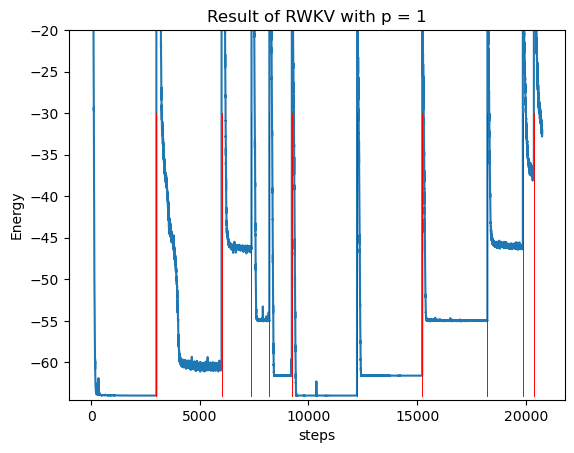

In [97]:
plt.plot(jnp.arange(meanE.shape[0]), meanE)
for i in line:
    plt.plot([i, i], [-64, -30], 'r', linewidth=0.7)
plt.ylim(-64.5, -20)
plt.xlabel("steps")
plt.ylabel("Energy")
plt.title("Result of RWKV with p = 1")

In [98]:
jnp.arange(11)*0.05*jnp.pi

Array([0.        , 0.15707964, 0.31415927, 0.47123894, 0.62831855,
       0.7853982 , 0.9424779 , 1.0995574 , 1.2566371 , 1.4137168 ,
       1.5707964 ], dtype=float32, weak_type=True)

(array([  6.,  27., 131., 298., 489., 475., 350., 149.,  61.,  14.]),
 array([-3.32512403, -2.67587066, -2.02661705, -1.37736368, -0.72811019,
        -0.07885671,  0.57039678,  1.21965027,  1.86890364,  2.51815724,
         3.16741061]),
 <BarContainer object of 10 artists>)

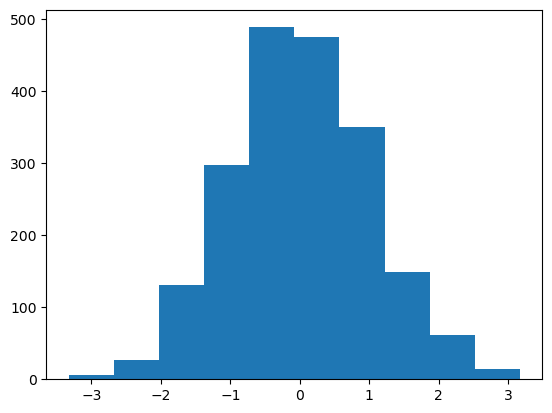

In [60]:
plt.hist((b@a-jnp.mean(b@a))/jnp.std(b@a))

In [2]:
import jax
import pickle
import jax.numpy as jnp
with open('params/params_L4_numsamples128_numunits4_rnntype_RWKV_rotation_True_angle0.3141592653589793.pkl', 'rb') as file:
    a = pickle.load(file)

RWKV_part = a[29:]  # This will contain elements from params[0] to params[28]
# Combine them into the new structure
params = (a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9], a[10], a[11], a[12], a[13], a[14], a[15], a[16], a[17], a[18], a[19], a[20], a[21], a[22], a[23], a[24], a[25], a[26], a[27], a[28], RWKV_part)

In [51]:
print(RWKV_part[8])

[[[[-5.0134377 -4.5999002 -4.293059  ...  2.8252497  2.910975
     3.0000076]
   [-5.0300803 -5.008394  -4.891612  ...  2.7153285  2.864999
     2.999089 ]
   [-4.9637814 -4.969294  -4.8198314 ...  2.6029682  2.804292
     3.0000606]
   [-4.93078   -4.95347   -5.0239058 ...  2.5019543  2.69381
     2.9994202]]

  [[-4.945738  -4.5919914 -4.237987  ...  2.8272853  2.9113345
     3.0005283]
   [-5.012109  -5.0444365 -4.934914  ...  2.7111292  2.8561795
     2.9999695]
   [-4.94036   -5.0174475 -4.910972  ...  2.6063514  2.801672
     2.999827 ]
   [-4.9511395 -5.0130234 -5.0625596 ...  2.5782323  2.7301474
     2.999673 ]]

  [[-4.9032855 -4.537838  -4.3098483 ...  2.8130867  2.9129019
     3.0005627]
   [-5.074674  -4.943962  -4.8654523 ...  2.7109554  2.856976
     2.999972 ]
   [-5.055991  -4.9967976 -4.937926  ...  2.5879858  2.8026557
     3.0000162]
   [-4.994703  -5.0067377 -5.0516443 ...  2.434115   2.7525933
     2.999936 ]]

  [[-4.932931  -4.543366  -4.2373753 ...  2.821062   

In [61]:
print(RWKV_part[9])

[[[[-1.6149085  -1.1700045  -0.69952494 ... -1.2016588  -0.7309297
    -1.6940085 ]
   [-1.7497382  -1.1807888  -0.67618823 ... -1.1236928  -0.742996
    -1.6527205 ]
   [-1.8447335  -1.2479618  -0.6906165  ... -1.1480905  -0.8503781
    -1.6437966 ]
   [-1.807436   -1.0555807  -0.8025814  ... -1.2801207  -0.691108
    -1.6490577 ]]

  [[-1.67452    -1.2500192  -0.7645985  ... -1.2171737  -0.58750767
    -1.7029349 ]
   [-1.7199824  -1.2445722  -0.7277808  ... -1.1132917  -0.69309276
    -1.6673602 ]
   [-1.6247469  -1.1690601  -0.58486146 ... -1.1835499  -0.65161926
    -1.7047948 ]
   [-1.7203814  -1.2141584  -0.88425624 ... -1.2665551  -0.83068967
    -1.7036622 ]]

  [[-1.7411804  -1.257325   -0.64183795 ... -1.2311928  -0.7110355
    -1.6901618 ]
   [-1.6607584  -1.2040884  -0.7187772  ... -1.1724224  -0.80077535
    -1.7501286 ]
   [-1.6788352  -1.2172216  -0.7131477  ... -1.0872823  -0.5733476
    -1.5795779 ]
   [-1.7316604  -1.1517369  -0.7047747  ... -1.0982475  -0.7979998
  

In [60]:
1/jnp.exp(jnp.exp(3))

Array(1.8921786e-09, dtype=float32, weak_type=True)

In [58]:
jnp.exp(-5)

Array(0.00673795, dtype=float32, weak_type=True)